In [1]:
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import utils
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression

# Warning suppression
import warnings
from sklearn.exceptions import ConvergenceWarning

In [2]:
df = pd.read_csv('data/diabetes_binary_health_indicators_BRFSS2015.csv')
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [3]:
X = df.copy().drop('Diabetes_binary', axis=1)
y = df['Diabetes_binary'].copy()
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Diabetes_binary, dtype: float64

In [4]:
df['Diabetes_binary'].value_counts()

Diabetes_binary
0.0    218334
1.0     35346
Name: count, dtype: int64

In [5]:
vif_list = utils.vif_removal_priority(X, 10)
vif_list

[['Education', 29.507416450234114],
 ['CholCheck', 22.235530259486595],
 ['AnyHealthcare', 18.1270116599421],
 ['BMI', 14.66476984201411]]

In [6]:
X = X.drop(['CholCheck', 'Education', 'AnyHealthcare', 'BMI'], axis=1)
X.head()

,HighBP,HighChol,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Income
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,3.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,1.0
2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,8.0
3,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,6.0
4,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,4.0


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(len(X_train))

190260


In [8]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
print(len(X_resampled))
print(len(X_test))

53166
63420


In [9]:
lrm = utils.create_model(utils.Model.LOGISTIC_REGRESSION, {'random_state': 42})
lrm_us = utils.create_model(utils.Model.LOGISTIC_REGRESSION, {'random_state': 42})

lrm.fit(X_train, y_train)
lrm_us.fit(X_resampled, y_resampled)

pred = lrm.predict(X_test)
pred_us = lrm_us.predict(X_test)

results = []

results.append({
    'name': 'Baseline LRM',
    'acc_score': accuracy_score(y_test, pred),
    'train_score': lrm.score(X_train, y_train),
    'test_score': lrm.score(X_test, y_test),
    'balanced_score': balanced_accuracy_score(y_test, pred)
})
results.append({
    'name': 'Undersampled LRM',
    'acc_score': accuracy_score(y_test, pred_us),
    'train_score': lrm_us.score(X_resampled, y_resampled),
    'test_score': lrm_us.score(X_test, y_test),
    'balanced_score': balanced_accuracy_score(y_test, pred_us)
})

results_df = pd.DataFrame(results)
results_df

c:\Users\fuze0\anaconda3\envs\dev\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\fuze0\anaconda3\envs\dev\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

,name,acc_score,train_score,test_score,balanced_score
0,Baseline LRM,0.860360,0.859655,0.860360,0.548257
1,Undersampled LRM,0.720183,0.731088,0.720183,0.735708


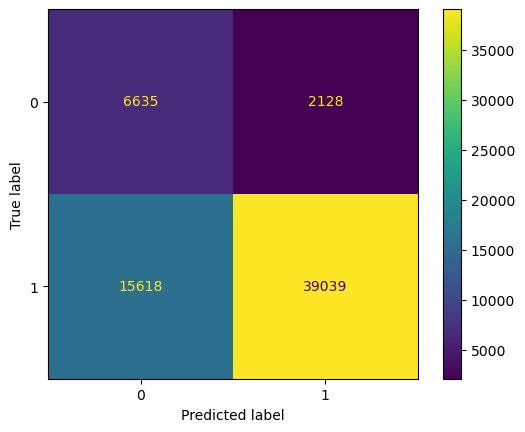

In [10]:
cmd = utils.confusion_matrix_plot(y_test, pred_us, [1, 0])
cmd.plot()

In [11]:
lrm = utils.create_model(utils.Model.LOGISTIC_REGRESSION, {'random_state': 42})
lrm.fit(X_resampled, y_resampled)

c:\Users\fuze0\anaconda3\envs\dev\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [12]:
pred = lrm.predict(X_test)

In [13]:
print(classification_report(y_test, pred,
                            target_names=["negative", "positive"]))

              precision    recall  f1-score   support

    negative       0.95      0.71      0.81     54657
    positive       0.30      0.76      0.43      8763

    accuracy                           0.72     63420
   macro avg       0.62      0.74      0.62     63420
weighted avg       0.86      0.72      0.76     63420



In [14]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100], #, 1000],  
    'tol': [0.01, 0.001, 0.0001, 0.00001], #, 0.001, 0.0001], 
    'solver': ['newton-cholesky', 'sag', 'saga'],
    'penalty': ['l2', None],
    'max_iter': [50, 100, 200]
}

lrm_grid = LogisticRegression()
grid = GridSearchCV(lrm_grid, param_grid, verbose=3, n_jobs=5)
# grid = GridSearchCV(lrm_grid, param_grid, verbose=3)
grid.fit(X_resampled, y_resampled)


Fitting 5 folds for each of 360 candidates, totalling 1800 fits


GridSearchCV(estimator=LogisticRegression(), n_jobs=5,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'max_iter': [50, 100, 200], 'penalty': ['l2', None],
                         'solver': ['newton-cholesky', 'sag', 'saga'],
                         'tol': [0.01, 0.001, 0.0001, 1e-05]},
             verbose=3)

In [15]:
print(grid.best_params_) 
grid_pred = grid.predict(X_test)
print(classification_report(y_test, grid_pred, target_names=['negative', 'positive']))

{'C': 1, 'max_iter': 200, 'penalty': None, 'solver': 'sag', 'tol': 0.01}
              precision    recall  f1-score   support

    negative       0.95      0.71      0.81     54657
    positive       0.30      0.76      0.43      8763

    accuracy                           0.72     63420
   macro avg       0.62      0.73      0.62     63420
weighted avg       0.86      0.72      0.76     63420

